## Evaluating Approximated Ratios

In order to evaluate the quality of the approximated ratios we can use the fact that 
$$\frac{p(x|\theta_1)}{p(x|\theta_0)}\cdot p(x|\theta_0) = p(x|\theta_1)$$
The algorithms works as follow:
 1. Compute the approximated density ratios for $p(x|\theta_1)$ and $p(x|\theta_0)$.
 2. Compute the values of the ratio $p(s(x)|\theta_1)/p(s(x)|\theta_0)$ for data $\in \theta_0$.
 3. Resample the data $\in \theta_0$ using the ratio values as weight.
 4. Train a classifier to separate between data $\in \theta_1$ and the resampled dataset. Is expected that the classifier will works badly if the original data and the resampled data follows the same distribution. This only happens if the density ratios are being approximated correctly.
 5. Evaluate the ROC curves of the classifier in the data. AUC = 0.5 means that the density ratios were approximated correcly. Better AUC show that the approximation is bad.
 
In what follows we will show how to compute and evaluate the approximated density ratios.

In [1]:
import ROOT
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy import ndimage

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from utils import printFrame,makePlotName
import time

import numpy as np

import os

np.random.seed(1234)

ROOT.gROOT.SetBatch(ROOT.kTRUE)

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using Theano backend.
/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Setting some global variables (features, classifier used to approximate the ratios).

In [2]:
workspace_file = 'workspace_evaluating.root'
dir='evaluating'
model_g='mlp'
verbose_printing=False

Define the models from where the data will be sampled. In this case 2 multivariate normal distributions.

In [3]:
# read mnist data
# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data augmentation?
#A = img.shape[0] / 3.0
#w = 2.0 / img.shape[1]
#shift = lambda x: A * np.sin(2.0*np.pi*x * w)
#for i in range(img.shape[0]):
#    img[:,i] = np.roll(img[:,i], int(shift(i)))

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print y_train

(60000, 'train samples')
(10000, 'test samples')
[5 0 4 ..., 5 6 8]


In [4]:
# Generating datasets
X_train_1 = X_train[y_train == 3]
X_test_1 = X_test[y_test == 3]
y_train_1 = np.ones(X_train_1.shape[0])
y_test_1 = np.ones(X_test_1.shape[0])

X_train_rng = np.random.randint(256, size = (X_train_1.shape[0],X_train_1.shape[1])).astype('float32')
X_train_rng /= 255
X_test_rng = np.random.randint(256, size = (X_test_1.shape[0],X_test_1.shape[1])).astype('float32')
X_test_rng /= 255
y_train_rng = np.zeros(X_train_rng.shape[0])
y_test_rng = np.zeros(X_test_rng.shape[0])

X_train_ = np.vstack((X_train_1,X_train_rng))
y_train_ = np.append(y_train_1,y_train_rng)
X_test_ = np.vstack((X_test_1,X_test_rng))
y_test_ = np.append(y_test_1,y_test_rng)
y_train_ = np_utils.to_categorical(y_train_, 2)
y_test_ = np_utils.to_categorical(y_test_, 2)

print X_train_1.shape[0]
print X_train_rng.shape[0]


6131
6131


Sampling data from the distributions.

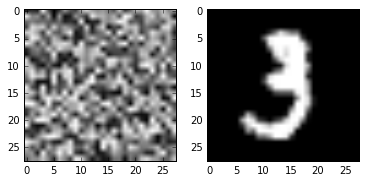

In [5]:
from matplotlib.pyplot import imshow, cm
# Plot mnist values
fig = plt.figure()
fig.add_subplot(121)

x_show = X_train_rng[10] * 255.
imshow(x_show.reshape((28,28)), cmap=cm.gray)

fig.add_subplot(122)

x_show = X_train_1[1] * 255.
imshow(x_show.reshape((28,28)), cmap=cm.gray)


Tran classifiers on the sampled data

In [6]:
# Define classifier model
batch_size = 128
nb_classes = 2
nb_epoch = 2

img_p = K.placeholder((1,784))

first_layer = Dense(512, input_shape=(784,))
first_layer.input = img_p
model = Sequential()
model.add(first_layer)
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))

rms = RMSprop()
model.compile(loss='mean_squared_error', optimizer=rms)

model.fit(X_train_, y_train_,
          batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=2,
          validation_data=(X_test_, y_test_))

score = model.evaluate(X_test_, y_test_,
                       show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Train on 12262 samples, validate on 2020 samples
Epoch 1/2
2s - loss: 0.0038 - acc: 0.9948 - val_loss: 4.6500e-05 - val_acc: 1.0000
Epoch 2/2
2s - loss: 6.0633e-05 - acc: 1.0000 - val_loss: 1.8564e-05 - val_acc: 1.0000
('Test score:', 1.856416494216445e-05)
('Test accuracy:', 1.0)


Compute score distributions.

In [ ]:
#grads = K.gradients(output, X_test_1[0])

In [7]:

bins = 300
low = 0.
high = 1.  
c1_g=''
  
print 'Generating Score Histograms'
w = ROOT.RooWorkspace('w')

w.factory('score[{0},{1}]'.format(low,high))
s = w.var('score')
  
def saveHisto(w,outputs,s,bins,low,high,k='F0',j='F1', name_sufix = ''):
    
    print 'Estimating {0} {1}'.format(k,j)
    for l,name in enumerate(['sig','bkg']):
      data = ROOT.RooDataSet('{0}data_{1}_{2}{3}'.format(name,k,j,name_sufix),"data",
          ROOT.RooArgSet(s))
      hist = ROOT.TH1F('{0}hist_{1}_{2}{3}'.format(name,k,j,name_sufix),'hist',bins,low,high)
      values = outputs[l]
      #values = values[self.findOutliers(values)]
      for val in values:
        hist.Fill(val)
        s.setVal(val)
        data.add(ROOT.RooArgSet(s))
      norm = 1./hist.Integral()
      hist.Scale(norm) 
        
      s.setBins(bins)
      datahist = ROOT.RooDataHist('{0}datahist_{1}_{2}{3}'.format(name,k,j,name_sufix),'hist',
            ROOT.RooArgList(s),hist)
      histpdf = ROOT.RooHistFunc('{0}histpdf_{1}_{2}{3}'.format(name,k,j,name_sufix),'hist',
            ROOT.RooArgSet(s), datahist, 1)

      getattr(w,'import')(hist)
      getattr(w,'import')(data)
      getattr(w,'import')(datahist) # work around for morph = w.import(morph)
      getattr(w,'import')(histpdf) # work around for morph = w.import(morph)
      score_str = 'score'
      # Calculate the density of the classifier output using kernel density 
      #w.factory('KeysPdf::{0}dist_{1}_{2}({3},{0}data_{1}_{2},RooKeysPdf::NoMirror,2)'.format(name,k,j,score_str))


outputs = [model.predict_proba(X_train_1, batch_size=batch_size)[:,1],
            model.predict_proba(X_train_rng, batch_size=batch_size)[:,1]]

dir = '.'
saveHisto(w,outputs,s, bins, low, high)
verbose_printing=True
if verbose_printing == True:
    can = printFrame(w,['score'],[w.function('sighistpdf_F0_F1'),w.function('bkghistpdf_F0_F1')], 
                     'generative_mnist_score',['signal','bkg'],
                      dir=dir,y_text='score(x)',print_pdf=True,title='Pairwise score distributions',
                      use_rootnotes=False)


Generating Score Histograms
6131/6131 [==============================] - 0s     
Estimating F0 F1


In [8]:
def findOutliers(x):
  q5, q95 = np.percentile(x, [5,95])  
  iqr = 2.*(q95 - q5)
  outliers = (x <= q95 + iqr) & (x >= q5 - iqr)
  return outliers
def singleRatio(f0,f1):
  ratio = f1 / f0
  ratio[np.abs(ratio) == np.inf] = 0 
  ratio[np.isnan(ratio)] = 0
  return ratio

def evalDist(x,f0,val):
  iter = x.createIterator()
  v = iter.Next()
  i = 0
  while v:
    v.setVal(val[i])
    v = iter.Next()
    i = i+1
  return f0.getVal(x)

In [9]:
# VERY raw estimation
epsilon = 1e-2
score = ROOT.RooArgSet(w.var('score'))
img_width = 28
img_height = 28

def evaldPdS(p_dist,s_val,epsilon):
    grad = (evalDist(score,p_dist,[s_val + epsilon]) - evalDist(score,p_dist,[s_val - epsilon])) / (2*epsilon)
    return grad
    
def continuity_loss(x):
    x_re = x.reshape((img_width,img_height))
    a = K.square(x_re[:img_width-1,:img_height-1] - x_re[1:,:img_height-1])
    b = K.square(x_re[:img_width-1,:img_height-1] - x_re[:img_width-1,1:])
    return K.sum(K.pow(a + b, 1.25))

reg_loss = K.variable(0.)
reg_loss += continuity_loss(img_p) / (img_width * img_height)
#reg_loss += K.sum(K.square(img_p)) / (img_width * img_height)

s_out = K.variable(0.)
x_out = model.get_output()

s_out += x_out[:,1][0]

grads = K.gradients(s_out, img_p)
grads_reg = K.gradients(reg_loss,img_p)

outputs = [s_out,grads]
outputs_reg = [reg_loss, grads_reg]

f_outputs = K.function([img_p], outputs)

f_outputs_reg = K.function([img_p], outputs_reg)

F0pdf = w.function('bkghistpdf_F0_F1')
F1pdf = w.function('sighistpdf_F0_F1')

def eval_loss_and_grads(X_val, epsilon, F1pdf = F1pdf, F0pdf = F0pdf):
    reg_alpha = 0.3
    s_output,dSdX = f_outputs([X_val.reshape((1,X_test_1.shape[1]))])
    reg, reg_grad = f_outputs_reg([X_val.reshape((1,X_test_1.shape[1]))])
    dPdS_1 = evaldPdS(F1pdf,s_output,epsilon)
    dPdS_0 = evaldPdS(F0pdf,s_output,epsilon)
    dlog_1 = evalDist(score,F1pdf,[s_output])
    dlog_0 = evalDist(score,F0pdf,[s_output])
    # TODO: Not sure if this is ok
    dlog_1 = dlog_1 if dlog_1 <> 0. else 1e-4
    dlog_0 = dlog_0 if dlog_0 <> 0. else 1e-4
    loss = - np.log(dlog_1) + np.log(dlog_0)
    dlog_1 = 1./dlog_1 if dlog_1 <> 0. else 0.
    dlog_0 = 1./dlog_0 if dlog_0 <> 0. else 0.
    loss = loss if not np.isinf(np.abs(loss)) else 0.
    grad =  dSdX*(dlog_0 * dPdS_0 - dlog_1 * dPdS_1)
    return loss + reg_alpha*reg, grad.flatten().astype('float64') + reg_alpha*reg_grad.flatten().astype('float64')
    
    
#print eval_loss_and_grads(X_test_rng[4])
#for i in range(10):
#    s_output, d_s =  f_outputs([X_test_rng[i].reshape((1,X_test_1.shape[1]))])
#    print s_output
#    print evaldPdS(F1pdf, s_output)
#    print evaldPdS(F0pdf, s_output)


In [10]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        self.epsilon = epsilon
        self.F1_pdf = None
        self.F0_pdf = None

    def loss(self, x):
        #assert self.loss_value is None
        if self.F1_pdf == self.F0_pdf == None:
            loss_value, grad_values = eval_loss_and_grads(x,epsilon)
        else:
            loss_value, grad_values = eval_loss_and_grads(x,epsilon,self.F1_pdf,self.F0_pdf)
    
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
    def set_epsilon(self,epsilon):
        self.epsilon = epsilon
    
    def set_distributions(self,F1_pdf, F0_pdf):
        self.F1_pdf = F1_pdf
        self.F0_pdf = F0_pdf
    
evaluator = Evaluator()

Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Elapsed Time: 432.84


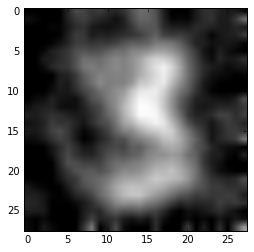

In [11]:
n_epochs_tran = 5

def transformDataset(X):
    for k in range(X.shape[0]):
        if k % 1000 == 0:
            print 'Processing {0}'.format(k)
        for e in range(n_epochs_tran):
            x = X[k]
            x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
            x_max = x.max()
            x = np.clip(x,0.,x_max) / x_max
            X[k] = x
    return X

X_train_sampled = np.copy(X_train_rng)
#x = np.copy(X_train_rng[0:10])
start_time = time.time()
X_train_sampled = transformDataset(X_train_sampled)
end_time = time.time()
elapsed_time = end_time - start_time
print 'Elapsed Time: {0:.2f}'.format(elapsed_time)

x = X_train_sampled[0]
x_show = x * 255.
filter_blurred_f = ndimage.gaussian_filter(x_show, 1)
alpha = 0.5
sharpened = x_show + alpha * (x_show - filter_blurred_f)

imshow(x_show.reshape((28,28)), cmap=cm.gray)

In [12]:
# Iterative algorithm used to sample data
n_iter = 5
# Full set of data to retrain
X_train_new = np.vstack((X_train_1,X_train_sampled))
    
verbose_printing=True

for it in range(n_iter):
    print 'Training iteration: {0}'.format(it)
    model.fit(X_train_new, y_train_,
          batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=2)    
    outputs = [model.predict_proba(X_train_1, batch_size=batch_size)[:,1],
            model.predict_proba(X_train_sampled, batch_size=batch_size)[:,1]]

    saveHisto(w,outputs, s, bins, low, high, name_sufix=it)
    F0_pdf = w.function('bkghistpdf_F0_F1{0}'.format(it))
    F1_pdf = w.function('sighistpdf_F0_F1{0}'.format(it))

    if verbose_printing == True:
        can = printFrame(w,['score'],[w.function('sighistpdf_F0_F1{0}'.format(it)),
                      w.function('bkghistpdf_F0_F1{0}'.format(it))], 
                     'generative_mnist_score',['signal','bkg'],
                      dir=dir,y_text='score(x)',print_pdf=True,title='Pairwise score distributions',
                      use_rootnotes=False)
    evaluator.set_distributions(F1_pdf, F0_pdf)
    X_train_sampled = transformDataset(X_train_sampled)
    X_train_new = np.vstack((X_train_1,X_train_sampled))
  


Training iteration: 0
Epoch 1/2
2s - loss: 0.0493 - acc: 0.9472
Epoch 2/2
2s - loss: 4.9186e-04 - acc: 1.0000
6131/6131 [==============================] - 0s     
Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 1
Epoch 1/2
2s - loss: 0.0275 - acc: 0.9693
Epoch 2/2
4s - loss: 0.0013 - acc: 0.9989
6131/6131 [==============================] - 0s     

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1



Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 2
Epoch 1/2
4s - loss: 0.0278 - acc: 0.9643
Epoch 2/2
6s - loss: 0.0059 - acc: 0.9935
6131/6131 [==============================] - 0s     
Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 3
Epoch 1/2
6s - loss: 0.0263 - acc: 0.9676
Epoch 2/2
7s - loss: 0.0066 - acc: 0.9922
6131/6131 [==============================] - 0s     

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1



Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 4
Epoch 1/2
7s - loss: 0.0234 - acc: 0.9726
Epoch 2/2
8s - loss: 0.0053 - acc: 0.9945
6131/6131 [==============================] - 0s     
Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1


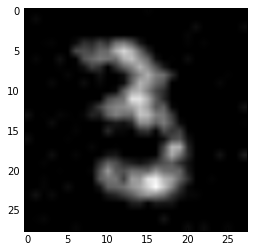

In [13]:
x = np.copy(X_train_sampled[0])
#x = transformDataset(x.reshape((1,x.shape[0])))

x_show = x * 255.
#filter_blurred_f = ndimage.gaussian_filter(x_show, 1)
#alpha = 0.5
#sharpened = x_show + alpha * (x_show - filter_blurred_f)

imshow(x_show.reshape((28,28)), cmap=cm.gray)

In [ ]:
import theano.tensor as tensor

def sgd(lr, x, evaluator):
    loss = evaluator.loss(x)
    new_x = x - lr * evaluator.grads(x)
    return new_x, loss
    

In [ ]:
x = X_test_rng[0]
lr = 0.3
start_time = time.time()

for i in range(50):
    #print('Start of iteration', i)

    # run L-BFGS for 7 steps
    x, min_val = sgd(lr, x, evaluator)
    # decode the dream and save it
    #print('Current loss value:', min_val)
    
    #if i % 10 == 0:
    #    x = (x  + X_test_rng[np.random.choice(len(X_test_rng))]) / 2.
    
    x = np.clip(x,0.,x.max())
    x = x / x.max()

end_time = time.time()
x_show = x * 255.
imshow(x_show.reshape((28,28)), cmap=cm.gray)